In [1]:
import numpy as np
from optiland import analysis, optic, optimization
from optiland.physical_apertures.rectangular import RectangularAperture
from optiland.analysis.irradiance import IncoherentIrradiance
from optiland.analysis.intensity import RadiantIntensity
from optiland.coordinate_system import CoordinateSystem
from optiland.materials import IdealMaterial, Material

from optiland.surfaces import Surface
from optiland.geometries import NurbsGeometry

import optiland.backend as be

In [ ]:
lens = optic.Optic(name="carta")

lens.set_field_type("angle")
lens.add_field(y=0)

lens.set_aperture(aperture_type="EPD", value=80)

lens.add_wavelength(value=0.587, is_primary=True)
val = 30
bar=RectangularAperture(
    y_max=val,
    y_min=-val,
    x_max=val,
    x_min=-val,
)
#lens.add_surface(index=0, radius=np.inf, thickness=np.inf)
lens.add_surface(index=0, z=np.inf, aperture=bar)
lens.add_surface(index=1, z=-100, aperture=bar)
#lens.add_surface(index=2, z=100, radius_y=200,radius_x=np.inf, material="mirror", rx=np.radians(-30), surface_type="toroidal", is_stop=True)


cs = CoordinateSystem(x=0, y=-15, z=0, rx=np.radians(-45), ry=0, rz=0, reference_cs=None)
nurbs_geo = NurbsGeometry(
    coordinate_system=cs,
    radius = 150,
    nurbs_norm_x = 80,
    nurbs_norm_y = 80,
    n_points_u = 2,
    n_points_v = 60,
)
n_control_points_u = nurbs_geo.P_size_u
n_control_points_v = nurbs_geo.P_size_v
material_post = IdealMaterial(n=1)
new_surface = Surface( geometry=nurbs_geo, material_post=material_post, previous_surface=lens.surface_group.surfaces[1])
new_surface.interaction_model.is_reflective = True
lens.add_surface(index=2, new_surface=new_surface, z=100)

carta_aperture = RectangularAperture(
    y_max=600,
    y_min=-600,
    x_max=50,
    x_min=-50,
)
lens.add_surface(index=3, z=-100, y=-650, aperture=carta_aperture, is_stop=True)
#lens.surface_group.surfaces[1].aperture = aperture
#lens.surface_group.surfaces[2].aperture = carta_aperture


(<Figure size 1000x400 with 1 Axes>, <Axes: xlabel='Z [mm]', ylabel='Y [mm]'>)

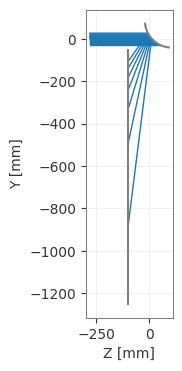

In [3]:
lens.draw(num_rays=20)

In [4]:
problem = optimization.OptimizationProblem()

for i in range(3):
    for j in range(n_control_points_u):
        for k in range(n_control_points_v):
            problem.add_variable(lens, "nurbs_control_point", surface_number=2, coeff_index = [i,j,k], min_val=-100, max_val=100)

for j in range(n_control_points_u):
    for k in range(n_control_points_v):
        problem.add_variable(lens, "nurbs_weight", surface_number=2, coeff_index = [j,k], min_val=0, max_val=10)

for i in range(10):
    input_data = {
        "optic": lens,           # Your lens system
        "surface_number": -1,     # Use -1 for the image plane
        "Hx": 0.0,                # Normalized Field X
        "Hy": 60/80 -i*2/10 * 60/80,                # Normalized Field Y (e.g., full field)
        "Px": 0.0,                # Normalized Pupil X
        "Py": 1-i*2/10,                # Normalized Pupil Y (e.g., chief ray)
        "wavelength": 0.587       # Wavelength in microns
        }
    problem.add_operand(
        operand_type="real_y_intercept",
        target=-45-i*1200/10,
        weight=1.0,
        input_data=input_data
    )
    problem.add_operand(
        operand_type="real_x_intercept",
        target=0,
        weight=1.0,
        input_data=input_data
    )

problem.info()


╒════╤════════════════════════╤═══════════════════╕
│    │   Merit Function Value │   Improvement (%) │
╞════╪════════════════════════╪═══════════════════╡
│  0 │            9.34118e+06 │                 0 │
╘════╧════════════════════════╧═══════════════════╛
╒════╤══════════════════╤══════════╤══════════════╤══════════════╤══════════╤═══════════╤══════════╤════════════════╕
│    │ Operand Type     │   Target │ Min. Bound   │ Max. Bound   │   Weight │     Value │    Delta │   Contrib. [%] │
╞════╪══════════════════╪══════════╪══════════════╪══════════════╪══════════╪═══════════╪══════════╪════════════════╡
│  0 │ real y intercept │      -45 │              │              │        1 │   -40.701 │    4.299 │           0    │
│  1 │ real x intercept │        0 │              │              │        1 │     0     │    0     │           0    │
│  2 │ real y intercept │     -165 │              │              │        1 │   135.44  │   86.508 │           0.08 │
│  3 │ real x intercept │       

In [5]:
optimizer = optimization.OptimizerGeneric(problem)
res = optimizer.optimize()
#optimizer = optimization.DifferentialEvolution(problem)
#res = optimizer.optimize(maxiter=10, workers=-1)
problem.info()

KeyboardInterrupt: 

1
1280


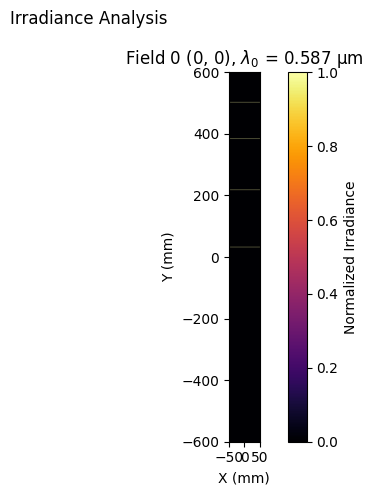

In [ ]:
irradiance = IncoherentIrradiance(
    lens,
    #num_rays=1000_000,  # 1 million rays
    num_rays=10,
    detector_surface=-1,  # image surface
    distribution="uniform",
    res=[1,1280]
)
irradiance.view(normalize=True)
irr_data = irradiance.data
print(irradiance.npix_x)
print(irradiance.npix_y)

In [ ]:
i = 0
for fblock in irr_data:
    for irr, *_ in fblock:
        irr_mean=be.mean(irr)
        irr_std=be.std(irr)
        irr_max=be.max(irr)
        irr_min=be.min(irr)

        if irr_mean > 0:
            rms_uniformity = irr_std / irr_mean
        else:
            rms_uniformity = 0

        if irr_mean > 0:
            irr_uniformity = (irr_max - irr_min) / irr_mean
        else:
            irr_uniformity = 0

print(irr_mean)
print(irr_uniformity)
print(rms_uniformity)
print(irr_max)
print(irr_min)

0.0002
320.0
17.86057109949175
0.064
0.0


In [ ]:
from optiland.fileio import save_optiland_file
save_optiland_file(lens, "optimization1.json")